In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C, RationalQuadratic
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data

In [ ]:
# Define the input data points as a NumPy array
X = np.array([
    [0.89698105, 0.72562797, 0.17540431, 0.70169437],
    [0.8893564,  0.49958786, 0.53926886, 0.50878344],
    [0.25094624, 0.03369313, 0.14538002, 0.49493242],
    [0.34696206, 0.0062504,  0.76056361, 0.61302356],
    [0.12487118, 0.12977019, 0.38440048, 0.2870761 ],
    [0.80130271, 0.50023109, 0.70664456, 0.19510284],
    [0.24770826, 0.06044543, 0.04218635, 0.44132425],
    [0.74670224, 0.7570915,  0.36935306, 0.20656628],
    [0.40066503, 0.07257425, 0.88676825, 0.24384229],
    [0.6260706,  0.58675126, 0.43880578, 0.77885769],
    [0.95713529, 0.59764438, 0.76611385, 0.77620991],
    [0.73281243, 0.14524998, 0.47681272, 0.13336573],
    [0.65511548, 0.07239183, 0.68715175, 0.08151656],
    [0.21973443, 0.83203134, 0.48286416, 0.08256923],
    [0.48859419, 0.2119651,  0.93917791, 0.37619173],
    [0.16713049, 0.87655456, 0.21723954, 0.95980098],
    [0.21691119, 0.16608583, 0.24137226, 0.77006248],
    [0.38748784, 0.80453226, 0.75179548, 0.72382744],
    [0.98562189, 0.66693268, 0.15678328, 0.8565348 ],
    [0.03782483, 0.66485335, 0.16198218, 0.25392378],
    [0.68348638, 0.9027701,  0.33541983, 0.99948256],
    [0.17034731, 0.75695908, 0.27652049, 0.5312315 ],
    [0.85965692, 0.91959232, 0.20613873, 0.09779683],
    [0.28213837, 0.50598691, 0.53053084, 0.09630162],
    [0.32607578, 0.4723669,  0.453192,   0.10588734],
    [0.94838936, 0.89451301, 0.85163782, 0.55219629],
    [0.66495539, 0.04656628, 0.11677747, 0.79371778],
    [0.57776561, 0.42877174, 0.42582587, 0.24900741],
    [0.73861301, 0.48210263, 0.70936644, 0.50397001],
    [0.8548108,  0.49396462, 0.73530997, 0.80809201],
    [0.533269, 0.396742, 0.064987, 0.180557],
    [0.400379, 0.405405, 0.352277, 0.427618],
    [0.287710, 0.032013, 0.965134, 0.051532],
    [0.378727, 0.362425, 0.452087, 0.420884],
    [0.078578, 0.050232, 0.961309, 0.983924],
    [0.056381, 0.884660, 0.190243, 0.706608],
    [0.056381, 0.884660, 0.190243, 0.706608],
    [0.765238, 0.068999, 0.953277, 0.970824],
    [0.069187, 0.891531, 0.956444, 0.989265],
    [0.421988, 0.397780, 0.372017, 0.419927],
    [0.436319, 0.338366, 0.367469, 0.430349],
    [0.386260, 0.425237, 0.424913, 0.414106]
])


# Define the corresponding target values as a NumPy array
y = np.array([
    -22.10828779, -14.60139663, -11.69993246, -16.05376511, -10.06963343,
    -15.48708254, -12.68168498, -16.02639977, -17.04923465, -12.74176599,
    -27.31639636, -13.52764887, -16.6791152,  -16.50715856, -17.81799934,
    -26.56182083, -12.75832422, -19.44155762, -28.90327367, -13.70274694,
    -29.4270914,  -11.56574199, -26.85778644,  -7.96677535,  -6.70208925,
    -32.62566022, -19.98949793,  -4.02554228, -13.12278233, -23.1394284,
    -9.55195154427133, 0.5642201608809363, -25.08445075957584, 0.03935436263451608,
    -34.76482197108209, -21.514290058883237, -21.514290058883237, -35.202081301532445,
    -39.57253899990339, 0.6013646121098479, 0.2809043177156565, 0.5941629048313968
])

## Surrogate model

Removing 0 outliers from evaluation training data
Training initial GPR model for evaluation on scaled training data...
Optimized kernel parameters: 2.56**2 * Matern(length_scale=2.98, nu=2.5) + WhiteKernel(noise_level=2.3e-12)
Log marginal likelihood: -6.693450896005597
Test MSE (initial evaluation): 3.4477295228038294
R² Score (initial evaluation): 0.9557893954797193


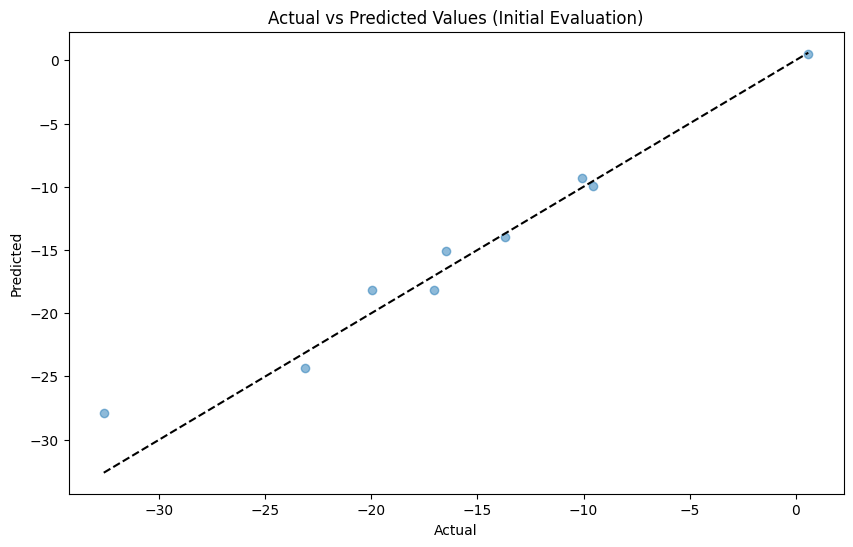

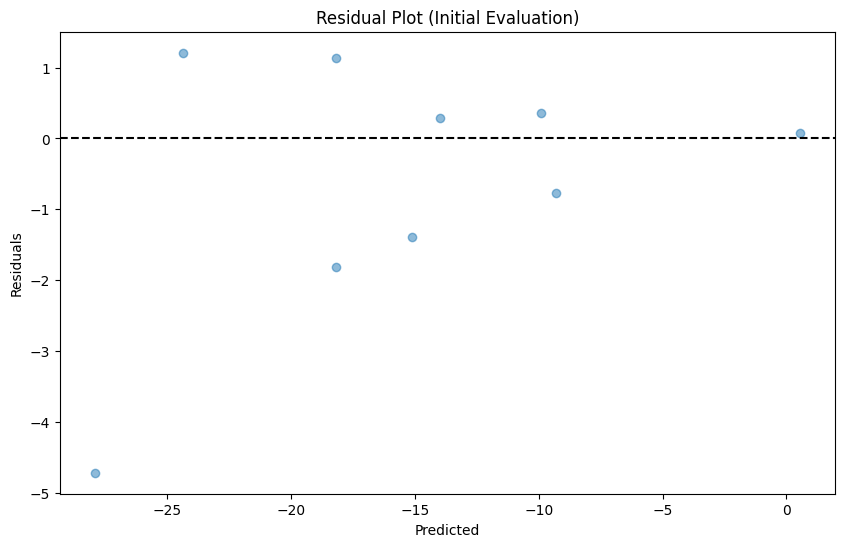

In [ ]:
# Define a more robust custom optimizer with increased max_iter and improved parameters
def custom_optimizer(obj_func, initial_theta, bounds):
    # Increase max iterations and add more parameters to improve convergence
    options = {
        'maxiter': 10000,  # Significantly increased max iterations
        'ftol': 1e-9,      # Function tolerance for convergence
        'gtol': 1e-7,      # Gradient tolerance for convergence
        'maxfun': 15000,   # Maximum number of function evaluations
        'maxls': 50        # Maximum number of line search steps
    }
    res = minimize(obj_func, initial_theta, method='L-BFGS-B', jac=True,
                   bounds=bounds, options=options)
    return res.x, res.fun

# --- Initial GPR setup and performance evaluation ---
# Split the initial data into training and testing sets for *initial evaluation* of the GPR performance.
# This split will NOT be used for the BO loop's training, but for showing the model's accuracy on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for and handle outliers in the *evaluation training* target variable
Q1 = np.percentile(y_train, 25)
Q3 = np.percentile(y_train, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_mask = (y_train >= lower_bound) & (y_train <= upper_bound)

print(f"Removing {np.sum(~outlier_mask)} outliers from evaluation training data")
X_train_filtered = X_train[outlier_mask]
y_train_filtered = y_train[outlier_mask]

# --- Ensure data is properly scaled for initial evaluation ---
# Create a robust scaler instance (global variable).
# This 'scaler' instance will be updated throughout the BO process.
global scaler
scaler = RobustScaler()
# Fit scaler only on evaluation training data
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test)  # Transform test data using the fitted scaler

# --- Define a more flexible kernel (global variable) ---
global kernel
kernel = C(0.8) * Matern(length_scale=0.52, nu=2.5) + \
                   WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1))

# Initialize the GPR model (global variable) with the custom optimizer.
# This 'gpr_model' instance will be updated throughout the BO process.
global gpr_model
gpr_model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=25,  # Increased number of restarts
    optimizer=custom_optimizer,
    random_state=0,
    normalize_y=True,         # Normalize target values
    alpha=1e-3               # Increased regularization to mitigate ConvergenceWarning
)

print("Training initial GPR model for evaluation on scaled training data...")
# Train the GPR model ONLY on the scaled evaluation training data for initial performance metrics
gpr_model.fit(X_train_scaled, y_train_filtered)

# Make predictions for initial evaluation
y_pred = gpr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimized kernel parameters: {gpr_model.kernel_}")
print(f"Log marginal likelihood: {gpr_model.log_marginal_likelihood(gpr_model.kernel_.theta)}")
print(f"Test MSE (initial evaluation): {mse}")
print(f"R² Score (initial evaluation): {r2}")

# Visualize predictions vs actual (for initial evaluation)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Initial Evaluation)')
plt.show()

# Plot residuals (for initial evaluation)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Initial Evaluation)')
plt.show()

# --- IMPORTANT FOR BO ---
# For Bayesian Optimization, we will use the *entire* accumulated X and y data to train the GPR model.
# The `scaler` and `gpr_model` global instances will be re-fitted on the growing dataset in the BO loop.

## Visualization

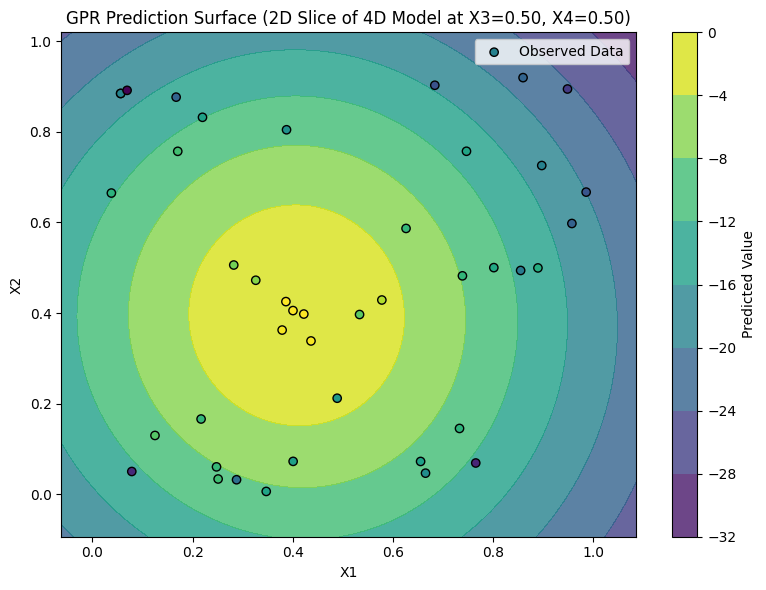

In [ ]:
# Create a meshgrid for plotting (using the first two features of X)
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                           np.linspace(y_min, y_max, 100))

# To make a 2D plot of a 4D model, we need to fix the remaining two features (X3, X4).
# A value of 0.5 is chosen as a neutral mid-point in a typically normalized feature space.
x3_fixed_value = 0.5
x4_fixed_value = 0.5


# Create candidate points for prediction on the meshgrid
# Combine the 2D meshgrid with the fixed features for prediction
x3_fixed_meshgrid = np.full(xx.ravel().shape, x3_fixed_value)
x4_fixed_meshgrid = np.full(xx.ravel().shape, x4_fixed_value)
candidate_points_meshgrid = np.c_[xx.ravel(), yy.ravel(), x3_fixed_meshgrid, x4_fixed_meshgrid]


# Predict on the meshgrid using the trained GPR model
# We need the gpr_model from the previous cell.
# Ensure the previous cell (training GPR) has been run.
try:
    # Scale the candidate points using the same scaler fitted on the training data
    candidate_points_meshgrid_scaled = scaler.transform(candidate_points_meshgrid)
    Z = gpr_model.predict(candidate_points_meshgrid_scaled)
    Z = Z.reshape(xx.shape)

    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # Create a single plot for GPR 4D visualization

    im = ax.contourf(xx, yy, Z, cmap=plt.cm.viridis, alpha=0.8)
    # Scatter plot the original data points using the first two features and color by target value
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, edgecolors='k', label='Observed Data')
    ax.set_title(f'GPR Prediction Surface (2D Slice of 4D Model at X3={x3_fixed_value:.2f}, X4={x4_fixed_value:.2f})')
    ax.set_xlabel('X1') # Explicitly set X1 label
    ax.set_ylabel('X2')
    fig.colorbar(im, ax=ax, label='Predicted Value')
    ax.legend()

    plt.tight_layout()
    plt.show()

except NameError:
    print("GPR model (gpr_model) not found. Please ensure the previous cell was run to train the model.")
except ValueError as e:
    print(f"An error occurred during prediction: {e}")
    print("This might happen if the GPR model was trained on a different number of features than what's provided for prediction.")
    print("Please ensure that the GPR model was trained on 4 features, and that 'X' at the time of its training was 4-dimensional.")

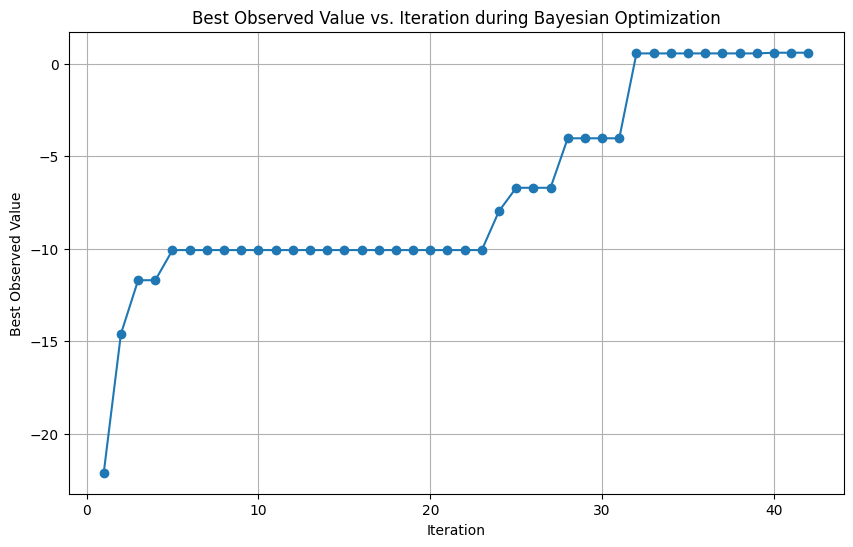

In [ ]:
# Assuming 'y' is the array of all observed values during the optimization
# Calculate the best observed value at each iteration
best_y_per_iteration = np.maximum.accumulate(y)

# Plot the best observed value per iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_y_per_iteration) + 1), best_y_per_iteration, marker='o', linestyle='-')
plt.title('Best Observed Value vs. Iteration during Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Best Observed Value')
plt.grid(True)
plt.show()


## Acquisition function

### Evaluate Candidate Points with UCB/EI/PI


In [ ]:
# Define a custom optimizer with increased max_iter for L-BFGS-B (re-declared for self-containment)
def custom_optimizer(obj_func, initial_theta, bounds):
    options = {
        'maxiter': 10000,
        'ftol': 1e-9,
        'gtol': 1e-7,
        'maxfun': 15000,
        'maxls': 50
    }
    res = minimize(obj_func, initial_theta, method='L-BFGS-B', jac=True,
                   bounds=bounds, options=options)
    return res.x, res.fun

# Define the UCB Acquisition Function
def upper_confidence_bound_gpr(X_new, model, kappa=0.1):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    upper_confidence_bound_value = mean_prediction + kappa * std_prediction
    return upper_confidence_bound_value

# Define the EI Acquisition Function
def expected_improvement_gpr(X_new, model, Y_best, xi=0.01):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    improvement = mean_prediction - Y_best - xi
    Z = improvement / std_prediction
    ei = improvement * norm.cdf(Z) + std_prediction * norm.pdf(Z)
    return np.maximum(0, ei)

# Define the PI Acquisition Function
def probability_of_improvement_gpr(X_new, model, Y_best, xi=0.01):
    mean_prediction, std_prediction = model.predict(X_new, return_std=True)
    std_prediction = np.maximum(std_prediction, 1e-9)
    improvement = mean_prediction - Y_best - xi
    Z = improvement / std_prediction
    pi = norm.cdf(Z)
    return pi

# --- Setup GPR model for Bayesian Optimization ---
# Ensure the global scaler and gpr_model are used and updated for the start of BO.
# These will be the instances used by the subsequent BO loop.
global scaler, gpr_model, kernel # Ensure access to global instances

scaler = RobustScaler() # Re-instantiate scaler to ensure clean state
X_full_scaled = scaler.fit_transform(X) # Fit scaler on the *entire* current X dataset

kernel = C(0.8) * Matern(length_scale=0.52, nu=2.5) + \
                   WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-12, 1e-1))

gpr_model = GaussianProcessRegressor( # Re-instantiate gpr_model
    kernel=kernel,
    n_restarts_optimizer=15,
    optimizer=custom_optimizer,
    random_state=0,
    normalize_y=True,
    alpha=1e-3 # Increased regularization to mitigate ConvergenceWarning
)

print("Training GPR model on all current data for Bayesian Optimization...")
gpr_model.fit(X_full_scaled, y) # Train on the *entire* current X and y
print("Gaussian Process Regressor model trained.")

# --- Generate Candidate Points for evaluating acquisition functions ---
# Define the bounds of the search space based on the observed data
x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
x3_min, x3_max = X[:, 2].min(), X[:, 2].max()
x4_min, x4_max = X[:, 3].min(), X[:, 3].max()


# --- Generating Random Points ---
n_random_points = 50000

random_candidate_points = np.random.uniform(low=[x1_min, x2_min, x3_min, x4_min],
                                            high=[x1_max, x2_max, x3_max, x4_max],
                                            size=(n_random_points, 4))

# Scale the random candidate points before passing them to the GPR model
random_candidate_points_scaled = scaler.transform(random_candidate_points)

# --- Evaluate Candidate Points with UCB, EI, and PI ---
kappa_ucb = 0.1
random_ucb_values_gpr = upper_confidence_bound_gpr(random_candidate_points_scaled, gpr_model, kappa=kappa_ucb)
max_ucb_index_random_gpr = np.argmax(random_ucb_values_gpr)
next_query_point_ucb = random_candidate_points[max_ucb_index_random_gpr]

current_best_y = np.max(y) # Get the current best observed value from the *entire* y
random_ei_values_gpr = expected_improvement_gpr(random_candidate_points_scaled, gpr_model, current_best_y)
max_ei_index_random_gpr = np.argmax(random_ei_values_gpr)
next_query_point_ei = random_candidate_points[max_ei_index_random_gpr]

xi_pi = 0.01
random_pi_values_gpr = probability_of_improvement_gpr(random_candidate_points_scaled, gpr_model, current_best_y, xi=xi_pi)
max_pi_index_random_gpr = np.argmax(random_pi_values_gpr)
next_query_point_pi = random_candidate_points[max_pi_index_random_gpr]

print("\nRecommended next query points based on each acquisition function:")
print(f"  UCB: {[f'{val:.6f}' for val in next_query_point_ucb]} (UCB value: {random_ucb_values_gpr[max_ucb_index_random_gpr]:.4f})")
print(f"  EI: {[f'{val:.6f}' for val in next_query_point_ei]} (EI value: {random_ei_values_gpr[max_ei_index_random_gpr]:.4f})")
print(f"  PI: {[f'{val:.6f}' for val in next_query_point_pi]} (PI value: {random_pi_values_gpr[max_pi_index_random_gpr]:.4f})")